In [30]:
#Import required libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation metrics
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, f1_score, confusion_matrix, classification_report
)



In [31]:
#load dataset and remove duplicates
df = pd.read_csv(r"D:\DigiHash\Avocado Price & Region Analysis\avocado.csv")
df.drop_duplicates(inplace=True)


print("Dataset Loaded Successfully")
print("Shape:", df.shape)
df.head()


Dataset Loaded Successfully
Shape: (18249, 14)


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


C:\Users\debaj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\debaj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


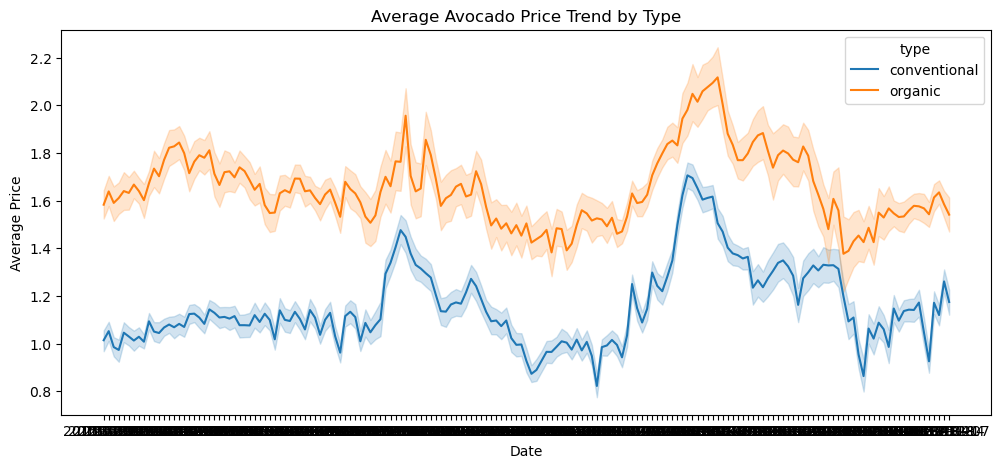

In [32]:
#Visualize price trend over time
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x="Date", y="AveragePrice", hue="type")
plt.title("Average Avocado Price Trend by Type")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.show()


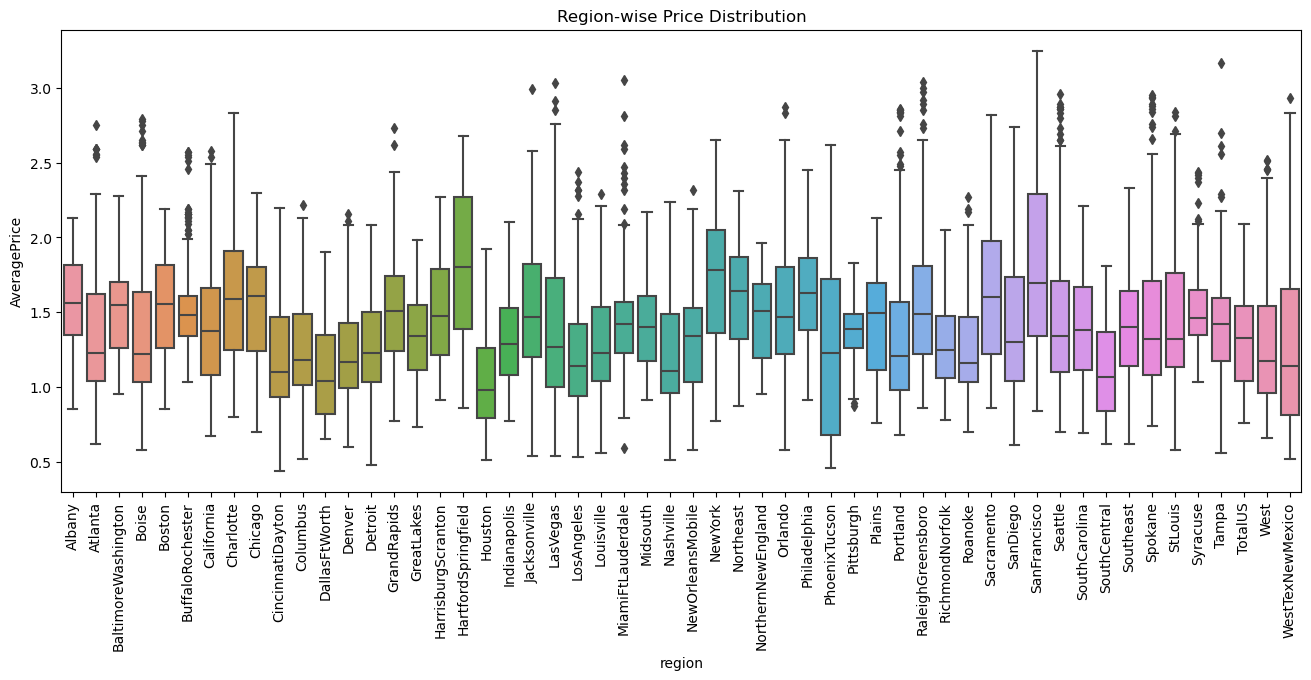

In [33]:
#visualize price distribution by region
plt.figure(figsize=(16,6))
sns.boxplot(data=df, x="region", y="AveragePrice")
plt.xticks(rotation=90)
plt.title("Region-wise Price Distribution")
plt.show()


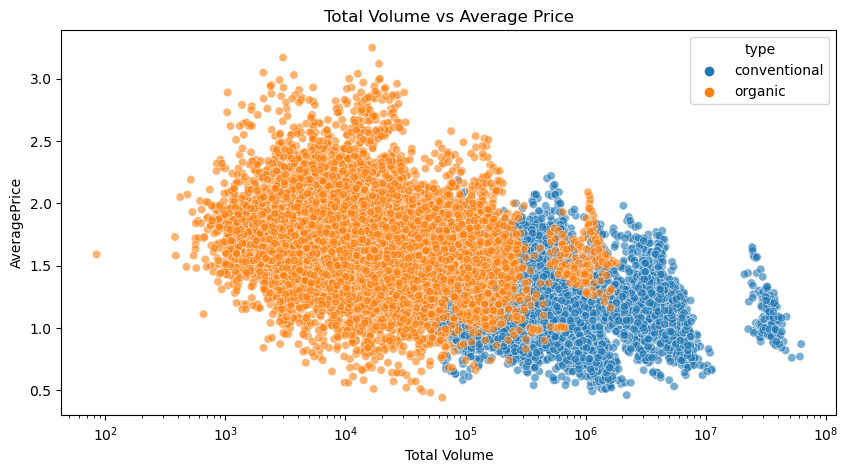

In [34]:
#visualized total value vs Average Price
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df,
    x="Total Volume",
    y="AveragePrice",
    hue="type",
    alpha=0.6
)
plt.xscale("log")
plt.title("Total Volume vs Average Price")
plt.show()


In [35]:
# Extract Month and Week from Date
df["Date"] = pd.to_datetime(df["Date"])
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)


In [36]:
# Create ratio feature
df["Small_Large_Ratio"] = df["Small Bags"] / (df["Large Bags"] + 1)



In [37]:
#PLU percentage
df["PLU_4046_Pct"] = df["4046"] / df["Total Volume"]
df["PLU_4225_Pct"] = df["4225"] / df["Total Volume"]
df["PLU_4770_Pct"] = df["4770"] / df["Total Volume"]

# Region price grouping
region_mean_price = df.groupby("region")["AveragePrice"].mean()

low_q = region_mean_price.quantile(0.33)
high_q = region_mean_price.quantile(0.66)

def assign_region_group(price):
    if price < low_q:
        return "Low"
    elif price < high_q:
        return "Medium"
    else:
        return "High"

df["Region_Price_Group"] = df["region"].map(
    region_mean_price.apply(assign_region_group)
)

In [38]:
# Encode categorical variables
le = LabelEncoder()
df["type_encoded"] = le.fit_transform(df["type"])
df["region_encoded"] = le.fit_transform(df["region"])
df["Region_Group_Encoded"] = le.fit_transform(df["Region_Price_Group"])

df.fillna(0, inplace=True)

print("Feature Engineering Completed")

Feature Engineering Completed


In [39]:
#select features and target variable
X_reg = df[
    ["Total Volume", "Small_Large_Ratio",
     "PLU_4046_Pct", "PLU_4225_Pct", "PLU_4770_Pct",
     "type_encoded", "Region_Group_Encoded",
     "Month", "Week", "region_encoded"]
]

y_reg = df["AveragePrice"]

#Training and Testing Split
X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [41]:
#Linear Regressio baseline
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_train_pred = lr.predict(X_train_scaled)
lr_test_pred = lr.predict(X_test_scaled)

print("Linear Regression")
print("Train R2 :", r2_score(y_train, lr_train_pred))
print("Test R2  :", r2_score(y_test, lr_test_pred))
print("RMSE    :", np.sqrt(mean_squared_error(y_test, lr_test_pred)))
print("MAE     :", mean_absolute_error(y_test, lr_test_pred))


Linear Regression
Train R2 : 0.4864809959800077
Test R2  : 0.47232335112391677
RMSE    : 0.29117232605979887
MAE     : 0.2249904613262621


In [42]:
#Random forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

rf_train_pred = rf_reg.predict(X_train)
rf_test_pred = rf_reg.predict(X_test)

print("\nRandom Forest Regressor")
print("Train R2 :", r2_score(y_train, rf_train_pred))
print("Test R2  :", r2_score(y_test, rf_test_pred))
print("RMSE    :", np.sqrt(mean_squared_error(y_test, rf_test_pred)))
print("MAE     :", mean_absolute_error(y_test, rf_test_pred))



Random Forest Regressor
Train R2 : 0.9824620659917696
Test R2  : 0.8738971748334099
RMSE    : 0.14234052593442134
MAE     : 0.10046665753424658


In [43]:
#apply GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train, y_train)

gb_train_pred = gb_reg.predict(X_train)
gb_test_pred = gb_reg.predict(X_test)

print("\nGradient Boosting Regressor")
print("Train R2 :", r2_score(y_train, gb_train_pred))
print("Test R2  :", r2_score(y_test, gb_test_pred))
print("RMSE    :", np.sqrt(mean_squared_error(y_test, gb_test_pred)))
print("MAE     :", mean_absolute_error(y_test, gb_test_pred))



Gradient Boosting Regressor
Train R2 : 0.7249751255256611
Test R2  : 0.6963196456756647
RMSE    : 0.22088921239137946
MAE     : 0.1676842949227689


In [44]:
#prepare features and target
X_cls = df[
    ["AveragePrice", "Total Volume", "Small_Large_Ratio",
     "PLU_4046_Pct", "PLU_4225_Pct", "PLU_4770_Pct",
     "Region_Group_Encoded", "Month", "region_encoded"]
]

y_cls = df["type_encoded"]


In [45]:
#training train split
X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
#apply LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

train_pred = log_model.predict(X_train)
test_pred = log_model.predict(X_test)

print("Logistic Regression")
print("Train Accuracy :", accuracy_score(y_train, train_pred))
print("Test Accuracy  :", accuracy_score(y_test, test_pred))
print("F1 Score       :", f1_score(y_test, test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
print("Classification Report:\n", classification_report(y_test, test_pred))



Logistic Regression
Train Accuracy : 0.9157476539489006
Test Accuracy  : 0.9090410958904109
F1 Score       : 0.9093886462882096
Confusion Matrix:
 [[1652  168]
 [ 164 1666]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1820
           1       0.91      0.91      0.91      1830

    accuracy                           0.91      3650
   macro avg       0.91      0.91      0.91      3650
weighted avg       0.91      0.91      0.91      3650



In [47]:
#Calculate ROC-AUC score
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1])
print("ROC-AUC:", roc)


ROC-AUC: 0.9714907223923617


In [48]:
#apply DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

train_pred = dt_model.predict(X_train)
test_pred = dt_model.predict(X_test)

print("\nDecision Tree Classifier")
print("Train Accuracy :", accuracy_score(y_train, train_pred))
print("Test Accuracy  :", accuracy_score(y_test, test_pred))
print("F1 Score       :", f1_score(y_test, test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
print("Classification Report:\n", classification_report(y_test, test_pred))



Decision Tree Classifier
Train Accuracy : 1.0
Test Accuracy  : 0.9923287671232877
F1 Score       : 0.9923413566739606
Confusion Matrix:
 [[1808   12]
 [  16 1814]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1820
           1       0.99      0.99      0.99      1830

    accuracy                           0.99      3650
   macro avg       0.99      0.99      0.99      3650
weighted avg       0.99      0.99      0.99      3650



In [49]:
#apply randomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)

print("\nRandom Forest Classifier")
print("Train Accuracy :", accuracy_score(y_train, train_pred))
print("Test Accuracy  :", accuracy_score(y_test, test_pred))
print("F1 Score       :", f1_score(y_test, test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
print("Classification Report:\n", classification_report(y_test, test_pred))



Random Forest Classifier
Train Accuracy : 1.0
Test Accuracy  : 0.9978082191780822
F1 Score       : 0.9978130125751776
Confusion Matrix:
 [[1817    3]
 [   5 1825]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1820
           1       1.00      1.00      1.00      1830

    accuracy                           1.00      3650
   macro avg       1.00      1.00      1.00      3650
weighted avg       1.00      1.00      1.00      3650



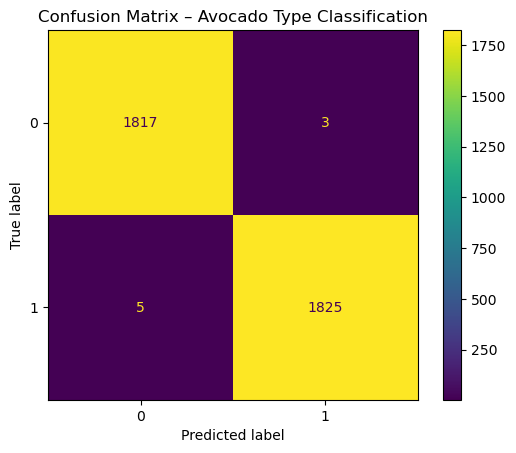

In [50]:
#apply confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(
    y_test, test_pred
)
plt.title("Confusion Matrix – Avocado Type Classification")
plt.show()

In [51]:
# comparison and detect which model is best

results = {

    "Logistic Regression": {
        "Train Accuracy": accuracy_score(y_train, log_model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, log_model.predict(X_test)),
        "F1 Score": f1_score(y_test, log_model.predict(X_test))
    },

    "Decision Tree": {
        "Train Accuracy": accuracy_score(y_train, dt_model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, dt_model.predict(X_test)),
        "F1 Score": f1_score(y_test, dt_model.predict(X_test))
    },

    "Random Forest": {
        "Train Accuracy": accuracy_score(y_train, rf_model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, rf_model.predict(X_test)),
        "F1 Score": f1_score(y_test, rf_model.predict(X_test))
    }

}
comparison_df = pd.DataFrame(results).T

print("\nClassification Model Comparison:")
print(comparison_df)
best_model = comparison_df.sort_values(by="Test Accuracy", ascending=False)

print("\nBest Classification Model:")
print(best_model.head(1))



Classification Model Comparison:
                     Train Accuracy  Test Accuracy  F1 Score
Logistic Regression        0.915748       0.909041  0.909389
Decision Tree              1.000000       0.992329  0.992341
Random Forest              1.000000       0.997808  0.997813

Best Classification Model:
               Train Accuracy  Test Accuracy  F1 Score
Random Forest             1.0       0.997808  0.997813


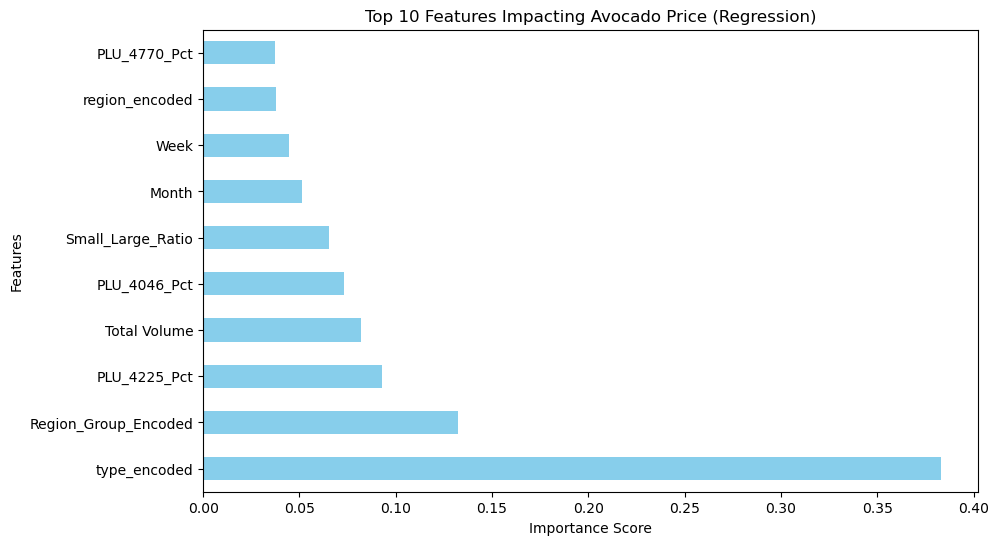

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance for Regression (Predicting AveragePrice)
plt.figure(figsize=(10, 6))
feat_importances_reg = pd.Series(rf_reg.feature_importances_, index=X_reg.columns)
feat_importances_reg.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Features Impacting Avocado Price (Regression)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


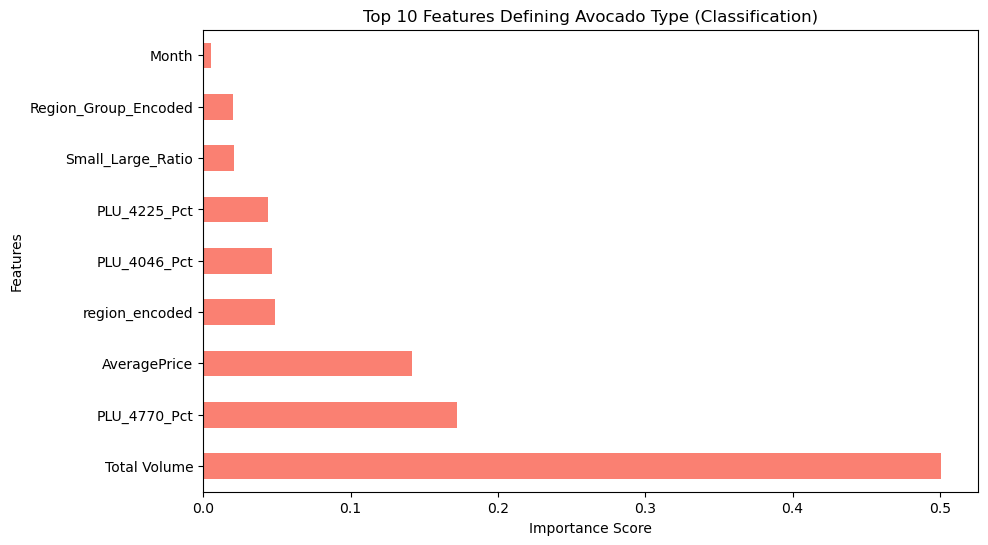

In [56]:
# Feature Importance for Classification (Predicting Type)
plt.figure(figsize=(10, 6))
feat_importances_cls = pd.Series(rf_model.feature_importances_, index=X_cls.columns)
feat_importances_cls.nlargest(10).plot(kind='barh', color='salmon')
plt.title("Top 10 Features Defining Avocado Type (Classification)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [57]:
print("Best Regression Model  : Random Forest Regressor")
print("Best Classification Model : Random Forest Classifier")


Best Regression Model  : Random Forest Regressor
Best Classification Model : Random Forest Classifier


In [58]:
#Save trained model
joblib.dump(rf_reg, "best_price_prediction_model.pkl")
joblib.dump(rf_model, "best_organic_type_model.pkl")

print("Models Saved Successfully")


Models Saved Successfully
